# Convolutional versus Dense layers in neural networks - Part 1

Convolutional layers in deep neural networks are known to have a dense (perceptron) equivalent. However, the topology of the convolutional layers is enforcing a parameter sharing: instead of copying parameters on several neurons, neurons are reused. This property of CNN is leading to a massive reduction in the number of coefficients.

In this series, we will show this property as well as some other interesting properties of CNN as compared to the dense equivalent.

In this first part, let's design the models to be compared and optimize the performance and size.

MNIST dataset of digits [[6](#References)] is well known as the initial use case of CNN by Lecun in 1998 [[1, 2](#References)]. Today, it remains one of the canonical datasets for machine learning training and algorithm comparisons.

Tensorflow's documentation has a Dense implementation of a classifier for the MNIST [[2](#References)]. Some implementations of the LeNet in Keras are also available [[3, 4](#References)].

Let's review these two architectures in the light of Tensorflow 2.0.

The classifiers studied in this notebook are quite different from the one of the _Classification of a 2D problem_ ([HTML](../classification/ClassificationMulti2Features-Keras.html) / [Jupyter](../classification/ClassificationMulti2Features-Keras.ipynb)). In that notebook the goal is to partition the hyper-plan of the features to match the labels. In this notebook, the features are pixels of images, the classifier partition is on the set of images. However, there is a great simplification compared to general image classification: on the MNIST dataset there is only a single digit per image.

### Learning goals:
- Examplify the equivalency of the convolutional and dense networks and show the decrease in number of coefficients
- Optimize the performance of the network through regularization using Dropout layers
- Optimize the size of the networks to get a fair comparison between the Dense and Convolution DNNs

In [ ]:
#!pip install tensorview

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import activations, datasets, layers, losses, metrics, models, optimizers, regularizers
import seaborn as sns
import tensorview as tv

### Helpers

In [0]:
def plotHeatMap(X, classes='auto', title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None,
               vmin=None, vmax=None, cbar=True):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, 
                     fmt=fmt, vmin=vmin, vmax=vmax, cbar=cbar, cmap=plt.cm.bwr, ax=ax) 
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

### MNIST Data

MNIST dataset is derived from the NIST dataset. It contains 60000 training and 10000 testing images of size 28x28 in grayscale. Digits have been recentered on the raster using the center of mass.

In [0]:
(xTrain, yTrain),(xTest, yTest) = datasets.mnist.load_data()
xTrain = xTrain / 255.0
xTest = xTest / 255.0

xTrain.shape

11493376/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

In [0]:
metricNames = ['Categorical cross-entropy', 'Accuracy']

## Dense Model design and performance

This implementation is taken from the Tensorflow tutorial [3].

The initial 28x28 pixel image is first flattened into a a vector of 784 features. 
These features are evaluated by 512 neurons in parallel. Their outputs are activated by the ReLU before being combined into the 10 output neurons giving softmax probabilities for each of the 10 digits.

A dropout layer is inserted in between the two layers. This layer is performing regularization in order to avoid overfitting [7].

In [0]:
modelDense0 = models.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(512, activation=activations.relu, name='dense_0'),
        layers.Dropout(0.2),
        layers.Dense(10, activation=activations.softmax, name='dense_1')
    ])

modelDense0.compile(optimizer=optimizers.Adam(),
                   loss=losses.sparse_categorical_crossentropy,
                   metrics=['accuracy'])

modelDense0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_0 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


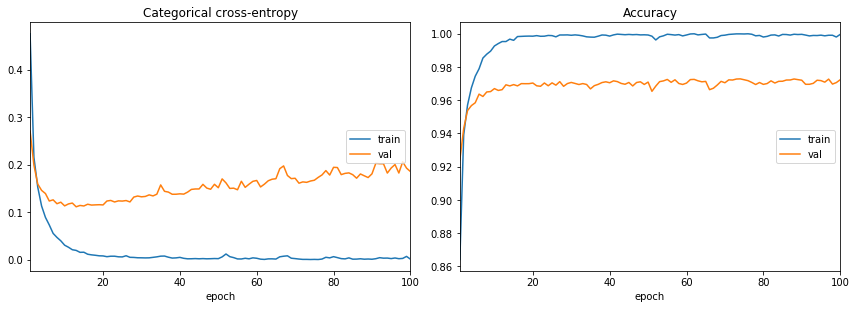

In [0]:
batchSize = 128
nEpochs = 100
tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=2)
historyDense0 = modelDense0.fit(xTrain, yTrain,
                epochs=nEpochs, batch_size=batchSize, 
                validation_split=0.7, 
                verbose=0,
                callbacks=[tvPlot]);

This model has __2 issues__:
- Even if there is regularization through the dropout layer there is still a quite large overfitting as the train and validation performance is quite different, and the validation loss is worsening from epoch 20 forward
- The variance of the validation loss and metric is high, hinting also for overfitting

In [0]:
loss, acc = modelDense0.evaluate(xTest, yTest, verbose=0)
print("Model Dense #0, test accuracy = %.2f %%" % (acc*100))

Model Dense #0, test accuracy = 97.47 %


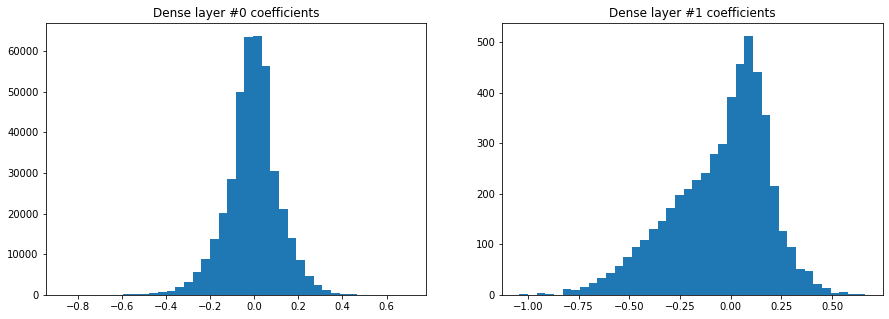

In [0]:
weightsDense0 = modelDense0.get_weights()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax, layerIndex, weightIndex in zip(axes, [0, 1], [0, 2]):
    ax.hist(weightsDense0[weightIndex].ravel(), density=False, bins=40)
    ax.set_title("Dense layer #%d coefficients" % layerIndex)

## Adding more regularization to the Dense network

The flatten layer has no training coefficients (weights, bias), but is transforming the topology of the feature space and is actually the wider feature space of the network (784 for this layer versus 512 at the next layer). Let's add a Dropout layer on this feature space. Also, as advised in [7], let's change the hidden layer dropout from 20% to 50%.

In [ ]:
modelDense1 = models.Sequential([
        layers.Flatten(input_shape=(28, 28), name='flatten'),
        layers.Dropout(0.2, name='dropout_0'),                             # <----
        layers.Dense(512, activation=activations.relu, name='dense_0'),
        layers.Dropout(0.5, name='dropout_1'),                             # <----
        layers.Dense(10, activation=activations.softmax, name='dense_1')
    ])

modelDense1.compile(optimizer=optimizers.Adam(),
       loss=losses.sparse_categorical_crossentropy,
       metrics=['accuracy']);

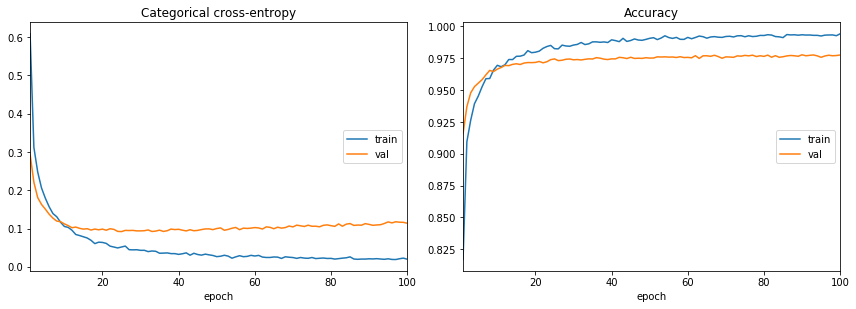

In [0]:
batchSize = 128
nEpochs = 100
tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=2)
historyDense1 = modelDense1.fit(xTrain, yTrain,
                epochs=nEpochs, batch_size=batchSize, 
                validation_split=0.7, 
                verbose=0,
                callbacks=[tvPlot]);

There is still overfitting on this network (delta between train and validation), but the variation on the validation curves are much lower and performance has increased by 0.7% (see below). The original paper on Dropout [7] is listing results better than 99% accuracy using a 2 layer dense network with 8096 units on each layer.

The validation metrics are better than the training during first epochs, this is a direct impact of the dropout: the training has fewer neurons active than the validation.

Moreover, on the histogram below for layer #0, many coefficients are at or close to 0. In the following section, we will attempt to decrease the model size while keeping similar performance.

In [0]:
loss, acc = modelDense1.evaluate(xTest, yTest, verbose=0)
print("Model Dense #0, test accuracy = %.2f %%" % (acc*100))

Model Dense #0, test accuracy = 97.84 %


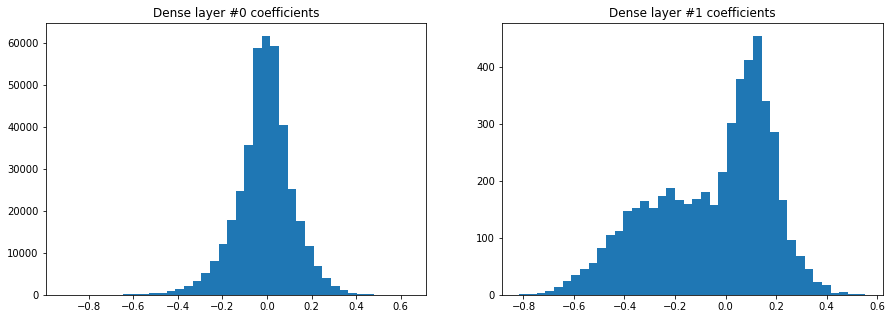

In [0]:
weightsDense1 = modelDense1.get_weights()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax, layerIndex, weightIndex in zip(axes, [0, 1], [0, 2]):
    ax.hist(weightsDense1[weightIndex].ravel(), density=False, bins=40)
    ax.set_title("Dense layer #%d coefficients" % layerIndex)

## Size optimized Dense model

This model seems overdesigned, many neurons are not used in layer #1. In order to have a fair comparison to the CNN implementation, let's optimize the number of neurons in layer #0.

In [0]:
batchSize = 128
nEpochs = 100

numNeuronsRange = [32, 64, 128, 256]
perfDense2 = []
for numNeurons in numNeuronsRange:
    modelDense = models.Sequential([
            layers.Flatten(input_shape=(28, 28)),
            layers.Dropout(0.2),
            layers.Dense(numNeurons, activation=activations.relu, name='dense_0'),
            layers.Dropout(0.5),
            layers.Dense(10, activation=activations.softmax, name='dense_1')
        ])

    modelDense.compile(optimizer=optimizers.Adam(),
           loss=losses.sparse_categorical_crossentropy,
           metrics=['accuracy'])

    historyDense = modelDense.fit(xTrain, yTrain,
            epochs=nEpochs, batch_size=batchSize, 
            validation_split=0.7, 
            verbose=0)
    
    perfDense2.append(modelDense.evaluate(xTest, yTest, verbose=0))
    print("Accuracy for %d neurons in layer #0 : %.2f %%" % (numNeurons, perfDense2[-1][1] * 100))

Accuracy for 32 neurons in layer #0 : 94.65 %
Accuracy for 64 neurons in layer #0 : 96.38 %
Accuracy for 128 neurons in layer #0 : 97.34 %
Accuracy for 256 neurons in layer #0 : 97.79 %


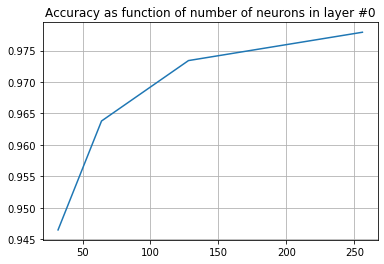

In [0]:
plt.plot(numNeuronsRange, np.array(perfDense2)[:,1])
plt.title("Accuracy as function of number of neurons in layer #0")
plt.grid()

Based on above grid search, in order to get a trade-off on performance and size, we select the first layer to be 128 neurons wide.

In [0]:
modelDense2 = models.Sequential([
            layers.Flatten(input_shape=(28, 28), name='flatten'),
            layers.Dropout(0.2, name='dropout_0'),
            layers.Dense(128, activation=activations.relu, name='dense_0'),
            layers.Dropout(0.5, name='dropout_1'),
            layers.Dense(10, activation=activations.softmax, name='dense_1')
        ])

modelDense2.compile(optimizer=optimizers.Adam(),
                   loss=losses.sparse_categorical_crossentropy,
                   metrics=['accuracy'])

modelDense2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dropout_0 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_0 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


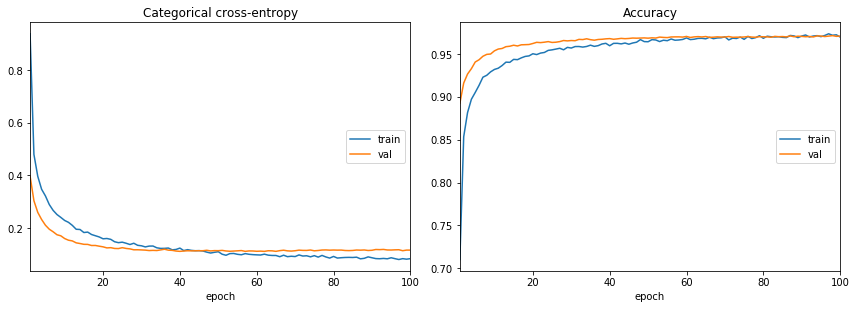

In [0]:
tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=2)
historyDense2 = modelDense2.fit(xTrain, yTrain,
                epochs=nEpochs, batch_size=batchSize, 
                validation_split=0.7, 
                verbose=0,
                callbacks=[tvPlot]);

The performance of the optimized network is the same as the original but with a quarter of the coefficients.

Also, overfitting is no longer visible on the loss and metrics curves.

In [0]:
loss, acc = modelDense2.evaluate(xTest, yTest, verbose=0)
print("Model Dense #1, test accuracy = %.2f %%" % (acc*100))

Model Dense #1, test accuracy = 97.34 %


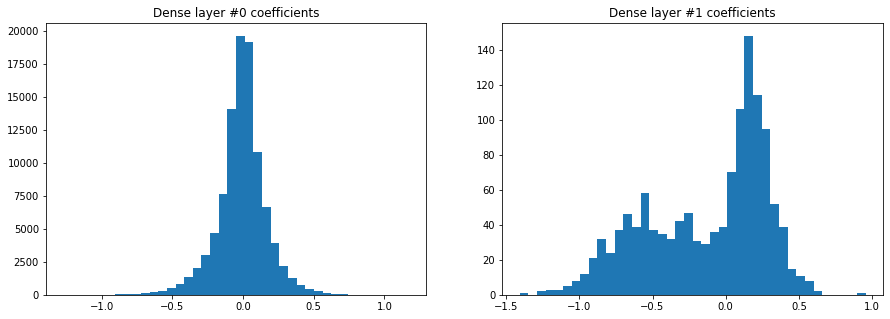

In [0]:
weightsDense2 = modelDense2.get_weights()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax, layerIndex, weightIndex in zip(axes, [0, 1], [0, 2]):
    ax.hist(weightsDense2[weightIndex].ravel(), density=False, bins=40)
    ax.set_title("Dense layer #%d coefficients" % layerIndex)

## LeNet model

Adapted from [4] in which the activation function is already the ReLU, original activation is Tanh. The network has two sections: convolutional and dense. 

The convolutional section is made of two pairs of convolutional + average pooling. The first pair operates 6 neurons on the input (30x30 pixels without padding), the second has 16 neurons on the 15x15x6 outputs of previous.

The images are padded to reach 32x32 pixels at input of the classifier and the dimension is increased to cope with the convolution layers.

In [0]:
imagePadWidth  = 32
imagePadHeight = 32
xTrainPad  = np.pad(xTrain.reshape(-1, 28, 28, 1), ((0,0),(2,2),(2,2),(0,0)), 'constant')
xTestPad   = np.pad(xTest.reshape(-1, 28, 28, 1), ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Padded image shape: {}".format(xTrainPad[0].shape))

Padded image shape: (32, 32, 1)


In [0]:
modelLeNet0 = models.Sequential([
    layers.Conv2D(filters=6, kernel_size=(3, 3), activation=activations.relu, 
                  input_shape=(imagePadWidth, imagePadHeight,1), name='conv_0'),
    layers.AveragePooling2D(),
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', name='conv_1'),
    layers.AveragePooling2D(),
    layers.Flatten(),
    layers.Dense(units=120, activation=activations.relu, name='dense_0'),
    layers.Dense(units=84, activation=activations.relu, name='dense_1'),
    layers.Dense(units=10, activation =activations.softmax, name='dense_2')])

modelLeNet0.compile(optimizer=optimizers.Adam(),
                   loss=losses.sparse_categorical_crossentropy,
                   metrics=['accuracy'])

modelLeNet0.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 6)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_0 (Dense)              (None, 120)               69240     
_________________________________________________________________
dense_1 (Dense)              (None, 84)               

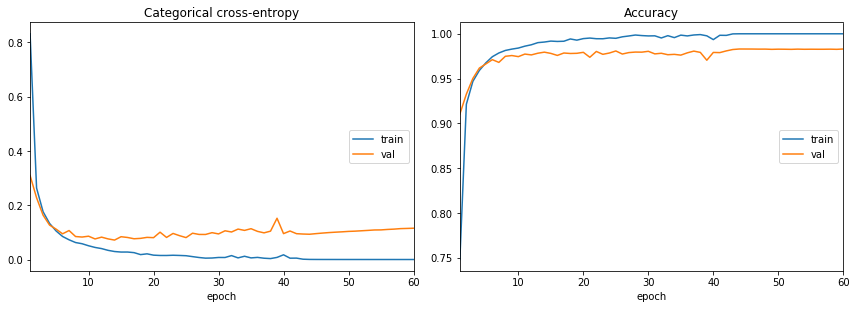

In [0]:
nEpochs = 60
tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=2)
historyLeNet0 = modelLeNet0.fit(xTrainPad, yTrain,
                epochs=nEpochs, batch_size=batchSize, 
                validation_split=0.7, 
                verbose=0,
                callbacks=[tvPlot]);

Optimization of this model is very quick. But is also overfitting and the train accuracy is reaching 100% while loss is flooring at 0.

In [0]:
loss, acc = modelLeNet0.evaluate(xTestPad, yTest, verbose=0)
print("Model LeNet #0, test accuracy = %.2f %%" % (acc*100))

Model LeNet #0, test accuracy = 98.60 %


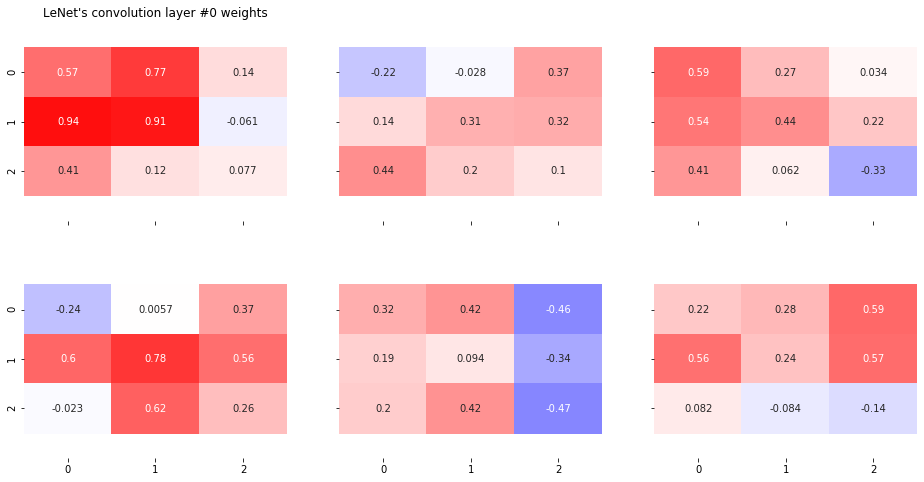

In [0]:
weightsLeNet0 = modelLeNet0.get_weights()

fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    plotHeatMap(weightsLeNet0[0][:,:, 0, i], [0, 1, 2], ax=ax, vmin=-1., vmax=1., cbar=False)

axes[0,0].set_title("LeNet's convolution layer #0 weights");

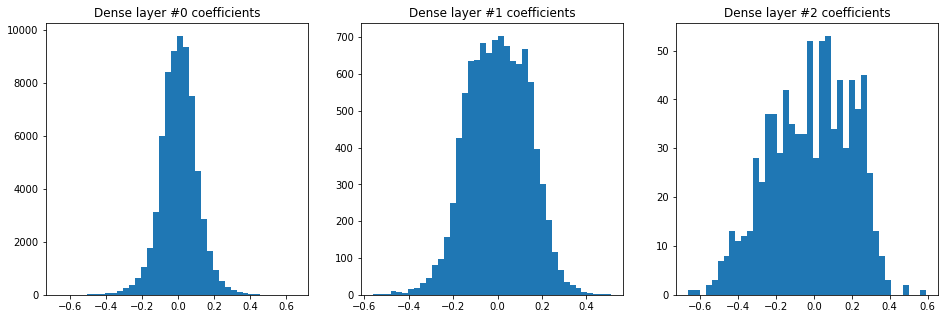

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for ax, layerIndex, weightIndex in zip(axes, [0, 1, 2], [4, 6, 8]):
    ax.hist(weightsLeNet0[weightIndex].ravel(), density=False, bins=40)
    ax.set_title("Dense layer #%d coefficients" % layerIndex)

### LeNet with L1-L2 regularization

In the following model, a mix of norm L1 (absolute value) and L2 (euclidian distance) is applied on the first dense layer in order to push the coefficients toward 0. This combination of regularization is also known as Elastic Net:
$$ \hat{\theta} = \underset{\theta \in \mathbb{R}^p, \lambda \in \mathbb{R}^+, \alpha \in [0, 1]}{argmin}\left[ \mathcal{L}(X, y, \theta) + \lambda \left(  \alpha \Vert \theta \Vert_1 + (1-\alpha) \frac 12 \Vert \theta \Vert_2^2 \right)\right] $$

With : 
- $X$, $y$ the features and labels
- $\theta$ the weights to learn
- $\mathcal{L}(X, y, \theta)$ the loss function
- $\lambda$, $\alpha$ the regularization parameters

In [0]:
modelLeNet1 = models.Sequential([
    layers.Conv2D(filters=6, kernel_size=(3, 3), activation=activations.relu, 
                  input_shape=(imagePadWidth, imagePadHeight,1), name='conv_0'),
    layers.AveragePooling2D(),
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation=activations.relu, 
                  name='conv_1'),
    layers.AveragePooling2D(),
    layers.Flatten(),
    layers.Dense(units=120, activation=activations.relu, 
                 kernel_regularizer=regularizers.l1_l2(0.00001, 0.00001), 
                 name='dense_0'),
    layers.Dense(units=84, activation=activations.relu, 
                 kernel_regularizer=regularizers.l1_l2(0.00001, 0.00001), 
                 name='dense_1'),
    layers.Dense(units=10, activation =activations.softmax,
                 name='dense_2')])

modelLeNet1.compile(optimizer=optimizers.Adam(),
                   loss=losses.sparse_categorical_crossentropy,
                   metrics=['accuracy'])

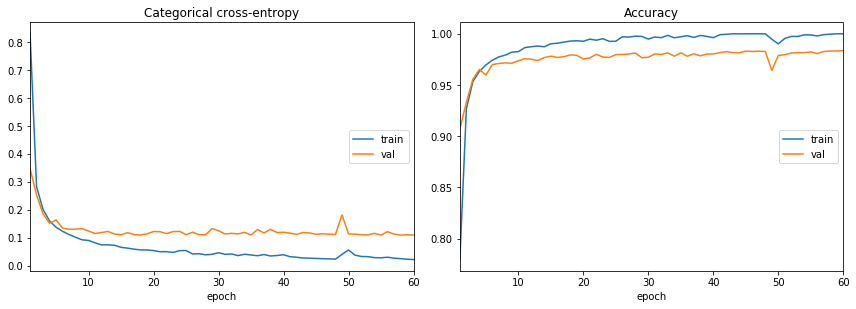

In [0]:
nEpochs = 60
tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=2)
historyLeNet1 = modelLeNet1.fit(xTrainPad, yTrain,
                epochs=nEpochs, batch_size=batchSize, 
                validation_split=0.7, 
                verbose=0,
                callbacks=[tvPlot]);

The performance of the CNN with L1-L2 regularization is very close to the original one. As shown on the histograms below, there are numerous coefficients close to 0, roome for network size optimization.

In [0]:
loss, acc = modelLeNet1.evaluate(xTestPad, yTest, verbose=0)
print("Model LeNet #1, test accuracy = %.2f %%" % (acc*100))

Model LeNet #1, test accuracy = 98.48 %


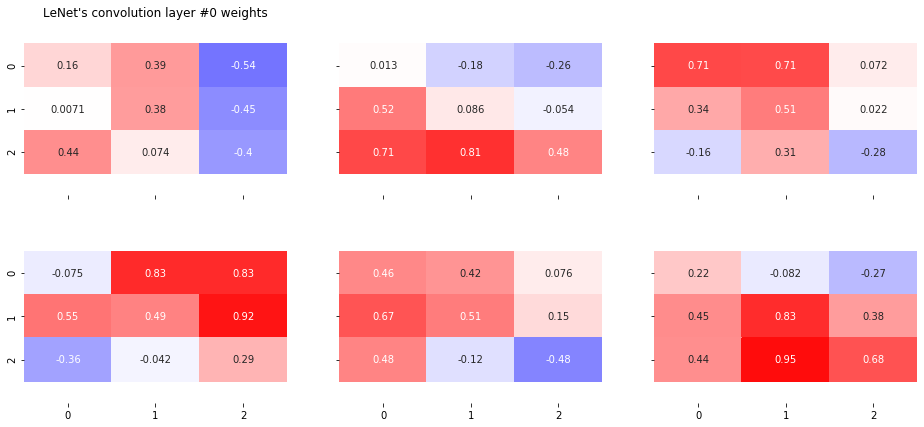

In [0]:
weightsLeNet1 = modelLeNet1.get_weights()

fig, axes = plt.subplots(2, 3, figsize=(16, 7), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    plotHeatMap(weightsLeNet1[0][:,:, 0, i], [0, 1, 2], ax=ax, vmin=-1., vmax=1., cbar=False)

axes[0,0].set_title("LeNet's convolution layer #0 weights");

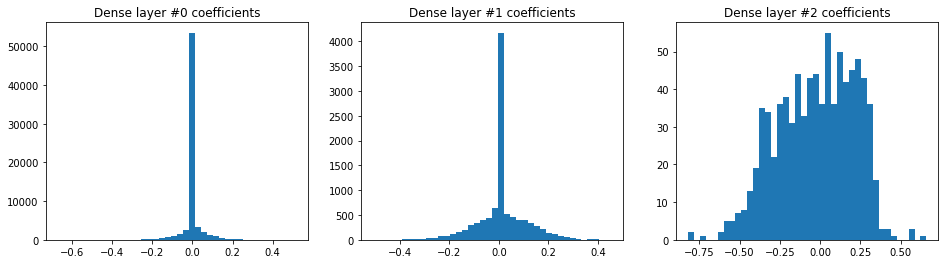

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for ax, layerIndex, weightIndex in zip(axes, [0, 1, 2], [4, 6, 8]):
    ax.hist(weightsLeNet1[weightIndex].ravel(), density=False, bins=40)
    ax.set_title("Dense layer #%d coefficients" % layerIndex)

## Size optimized LeNet with L1-L2 regularization

The first two dense layers have been halved. The regularization parameters have been decreased on the second dense layer as there should be less "extra" coefficients.

In [0]:
modelLeNet2 = models.Sequential([
    layers.Conv2D(filters=6, kernel_size=(3, 3), activation=activations.relu, 
                  input_shape=(imagePadWidth, imagePadHeight,1), name='conv_0'),
    layers.AveragePooling2D(),
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation=activations.relu, 
                  name='conv_1'),
    layers.AveragePooling2D(),
    layers.Flatten(),
    layers.Dense(units=60, activation=activations.relu, 
                 kernel_regularizer=regularizers.l1_l2(0.00001, 0.00001), 
                 name='dense_0'),
    layers.Dense(units=42, activation=activations.relu, 
                 kernel_regularizer=regularizers.l1_l2(0.000001, 0.000001), 
                 name='dense_1'),
    layers.Dense(units=10, activation =activations.softmax, 
              #   kernel_regularizer=regularizers.l1_l2(0.00001, 0.0001), 
                 name='dense_2')])

modelLeNet2.compile(optimizer=optimizers.Adam(),
                   loss=losses.sparse_categorical_crossentropy,
                   metrics=['accuracy'])

modelLeNet2.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d_10 (Averag (None, 15, 15, 6)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_11 (Averag (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_0 (Dense)              (None, 60)                34620     
_________________________________________________________________
dense_1 (Dense)              (None, 42)              

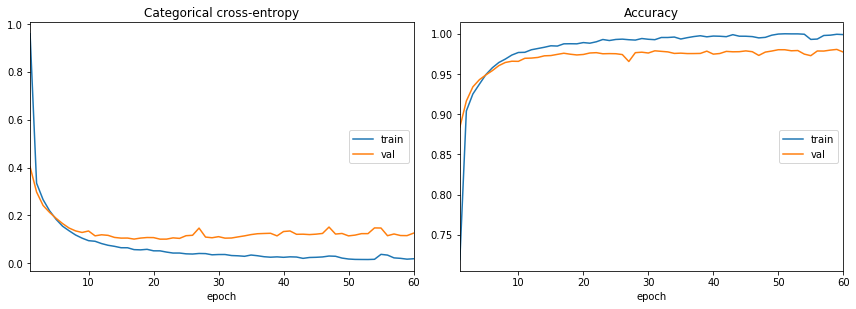

In [0]:
nEpochs = 60
tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=2)
historyLeNet2 = modelLeNet2.fit(xTrainPad, yTrain,
                epochs=nEpochs, batch_size=batchSize, 
                validation_split=0.7, 
                verbose=0,
                callbacks=[tvPlot]);

Optimized LeNet model is better than original LeNet performance but with 29% less coefficients and less overfitting.

In [0]:
loss, acc = modelLeNet2.evaluate(xTestPad, yTest, verbose=0)
print("Model LeNet #2, test accuracy = %.2f %%" % (acc*100))

Model LeNet #2, test accuracy = 98.20 %


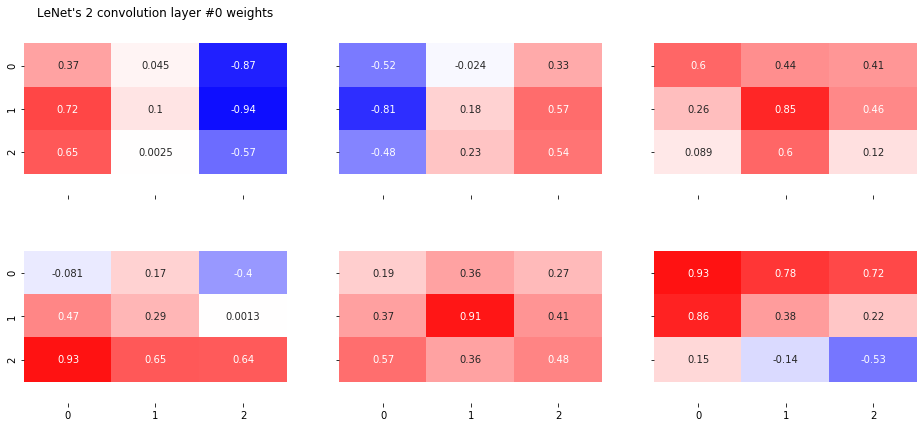

In [0]:
weightsLeNet2 = modelLeNet2.get_weights()

fig, axes = plt.subplots(2, 3, figsize=(16, 7), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    plotHeatMap(weightsLeNet2[0][:,:, 0, i], [0, 1, 2], ax=ax, vmin=-1., vmax=1., cbar=False)

axes[0,0].set_title("LeNet's 2 convolution layer #0 weights");

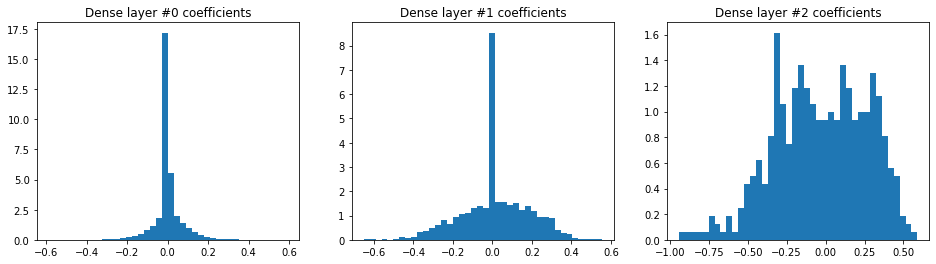

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for ax, layerIndex, weightIndex in zip(axes, [0, 1, 2], [4, 6, 8]):
    ax.hist(weightsLeNet2[weightIndex].ravel(), density=False, bins=40)
    ax.set_title("Dense layer #%d coefficients" % layerIndex)

## Size optimized LeNet with Dropout

Dropout is another very effective regularization technic in which a share of the layer (here the convolution layer #1 with 16 neurons) is disabled at each iteration. The selection of neurons to disable is random.

In [0]:
modelLeNet3 = models.Sequential([
    layers.Conv2D(filters=6, kernel_size=(3, 3), activation=activations.relu, 
                  input_shape=(imagePadWidth, imagePadHeight, 1), 
                  name='conv_0'),
    layers.AveragePooling2D(),
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation=activations.relu, 
                  name='conv_1'),
    layers.Dropout(0.2),                                 # <---
    layers.AveragePooling2D(),
    layers.Flatten(),
    layers.Dense(units=60, activation=activations.relu, 
                 name='dense_0'),
    layers.Dropout(0.5),                                 # <---
    layers.Dense(units=42, activation=activations.relu, 
                  name='dense_1'),
    layers.Dense(units=10, activation=activations.softmax, 
                 name='dense_2')])

modelLeNet3.compile(optimizer=optimizers.Adam(),
                   loss=losses.sparse_categorical_crossentropy,
                   metrics=['accuracy'])

modelLeNet3.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d_8 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 13, 13, 16)        880       
_________________________________________________________________
dropout_9 (Dropout)          (None, 13, 13, 16)        0         
_________________________________________________________________
average_pooling2d_9 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_0 (Dense)              (None, 60)              

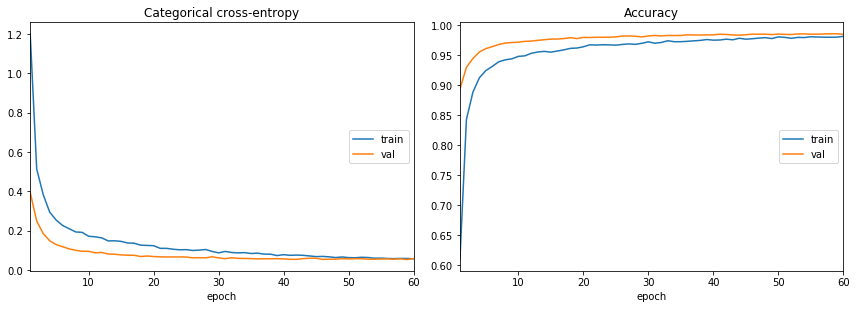

In [0]:
nEpochs = 60
tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=2)
historyLeNet3 = modelLeNet3.fit(xTrainPad, yTrain,
                epochs=nEpochs, batch_size=batchSize, 
                validation_split=0.7, 
                verbose=0, callbacks=[tvPlot]);

This model has the __best performance__ so far and 37% of the number of coefficients of the optimized dense model.

In [0]:
loss, acc = modelLeNet3.evaluate(xTestPad, yTest, verbose=0)
print("Model LeNet #3, test accuracy = %.2f %%" % (acc*100))

Model LeNet #3, test accuracy = 98.75 %


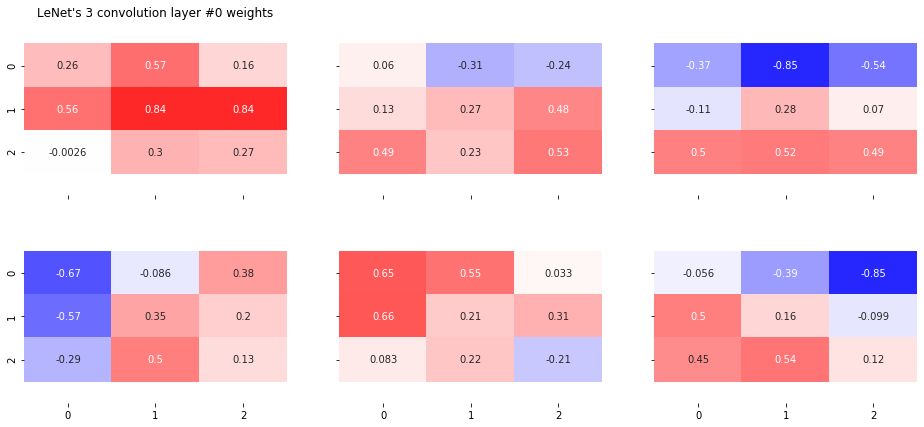

In [0]:
weightsLeNet3 = modelLeNet3.get_weights()

fig, axes = plt.subplots(2, 3, figsize=(16, 7), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    plotHeatMap(weightsLeNet3[0][:,:, 0, i], [0, 1, 2], ax=ax, vmin=-1., vmax=1., cbar=False)

axes[0,0].set_title("LeNet's 3 convolution layer #0 weights");

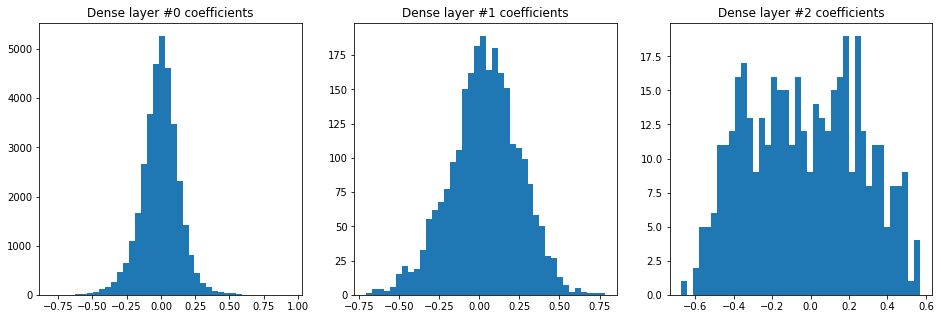

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for ax, layerIndex, weightIndex in zip(axes, [0, 1, 2], [4, 6, 8]):
    ax.hist(weightsLeNet3[weightIndex].ravel(), density=False, bins=40)
    ax.set_title("Dense layer #%d coefficients" % layerIndex)

# Conclusion

In this first part, we have designed and optimized for performance and size the Dense and "LeNet" classifiers for the MNIST digits. Here are our findings : 

| Network | Number of coefficients | Regularization | Accuracy on MNIST test |
|---------|------------------------|----------------|------------------------|
| Dense "Tensor Tutorial"| 407,050  | Single Dropout | ~97.5%                |
| Dense with improved regularization | 407,050 | 2 Dropout layers | ~97.8%   |
| Dense with 128 neurons             | 101,770 | 2 Dropout layers | ~97.3%   |
| LeNet with ReLU       | 81,194 | No regularization | ~98.6%                |
| LeNet with ReLU and Elasticnet | 81,194 | L1-L2 regularization on 2 dense layers | ~98.5% |
| LeNet with ReLU and Elasticnet, halved dense layers | 38,552 | L1-L2 regularization on 2 dense layers | ~98.2% |
| LeNet with ReLU and dropout, halved dense layers | __38,552__ | Dropout before 2 dense layers | __~98.7%__ |

In this notebook, two regularization technics were used in order to tune generalization properties (i.e. fight against overfitting) and performance. Dropout has been shown to be more effective than classical L1-L2 penalizations. There exist other regularizations technics like adding some (white) noise on the gradient, or early stopping.

## Where to go from here

- Part-2 coming soon, we will study the impact of geometry transformations (translation, rotation, scale...) on the two kinds of networks
- Classification of a 2D problem based on the Czech and Norvegian flags ([HTML](../classification/ClassificationMulti2Features-Keras.html) / [Jupyter](../classification/ClassificationMulti2Features-Keras.ipynb))
- Using convolutional layer as a linear filter to detect edges - Part 1 ([HTML](CnnEdgeDetection-Keras-Part1.html) / [Jupyter](CnnEdgeDetection-Keras-Part1.ipynb))

### References:
1. Gradient-Based Learning Applied to Document Recognition, Lecun et al. - http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf
2. Demonstrations on the LeNet classification of digits - http://yann.lecun.com/exdb/lenet/index.html
3. Dense implementation of the MNIST classifier - https://www.tensorflow.org/tensorboard/get_started
4. LeNet implementation with Tensorflow Keras - https://colab.research.google.com/drive/1CVm50PGE4vhtB5I_a_yc4h5F-itKOVL9
5. LeNet implementation with Tensorflow 1.0 - https://github.com/udacity/CarND-LeNet-Lab/blob/master/LeNet-Lab-Solution.ipynb
6. MNIST dataset - http://yann.lecun.com/exdb/mnist/
7. Dropout: A Simple Way to Prevent Neural Networks from Overfitting, Nitish Srivastava et al. - http://jmlr.org/papers/v15/srivastava14a.html